In [16]:
import xml.etree.cElementTree as ET
from IPython.display import clear_output
from ipywidgets import FloatProgress, IntText
from IPython.display import display
from nltk.tokenize.stanford import StanfordTokenizer
from nltk.tokenize import word_tokenize
import nltk
import time
import re
import pandas as pd
import collections
from math import log 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#nltk.download()

# Extracting Articles from Specific Categories

This is my first attempt at processing the Wikipedia dump.  It streamingly parses the Wikipedia XML and processes any article with a category tag that contains the specified strings.  Currently, it just writes the body of the articles to both a single file and a category specific file.  It probably should also do the tokenization, but doesn't yet.

In [7]:
class ArticleProcessor:
    
    def __init__(self, categories):
        self.categories = categories        
        self.global_matcher = re.compile("\[\[Category:[^\]]*(" + 
                                         "|".join(categories) + 
                                         ")[^\]]*", re.IGNORECASE)
        self.category_matcher = {}
        self.article_writer = {}
        self.global_writer = open("data/all-articles", "w")
        for category in self.categories:
            self.category_matcher[category] = re.compile("\[\[Category:[^\]]*" + 
                                                         category + 
                                                         "[^\]]*", re.IGNORECASE)
            self.article_writer[category] = open("data/" + category + "-articles", "w")
            
    def is_article_of_interest(self, article_text):
        return self.global_matcher.search(article_text)

    def process_article(self, article_text):
        self.global_writer.write(article_text)
        self.global_writer.write("\n")
        for category in self.categories:
            if self.category_matcher[category].search(article_text):
                self.article_writer[category].write(article_text)
                self.article_writer[category].write("\n")
    
    def close_all(self):
        self.global_writer.close()
        for writer in self.article_writer.values():
            writer.close()
    

In [10]:
#Don't run this

p = ET.iterparse("data/enwiki-20170820-pages-articles.xml", 
                 events=("start", "end"))

start = time.time()
article_count = 0
root = None
f = FloatProgress(min=0, max=17773690)
t = IntText(value=0, description="Articles")
m = IntText(value=0, description="Matching Articles")
display(t, m, f)

processor = ArticleProcessor(["sportspeople",
                              "artists",
                              "politicians",
                              "military personnel",
                              "scientist",
                              #sportmanager
                              #cleric
                              "monarch",
                              "Fictional\ characters",
                              "nobility",
                              "criminals",
                              "judges"
                              
                             ])
try:
    
    for event, elem in p:
        if root == None:
            root = elem
        if event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}text':
            article_count += 1
            if article_count % 1000 == 0:
                f.value = article_count
                t.value = article_count
            if elem.text and processor.is_article_of_interest(elem.text):
                m.value += 1 
                processor.process_article(elem.text)
            root.clear()
finally:
    processor.close_all()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Articles: 17773690 Time: 5338.332955360413 seconds


# Extracting Articles with Gender Labels

In [2]:
gender_label_table = pd.read_csv("data/wiki.genders.txt", sep='\t')
gender_label_table.head(10)

,wiki id,gender,name
0,307,MALE,Abraham Lincoln
1,339,FEMALE,Ayn Rand
2,340,MALE,Alain Connes
3,344,MALE,Allan Dwan
4,595,MALE,Andre Agassi
5,628,MALE,Aldous Huxley
6,676,MALE,Andrei Tarkovsky
7,700,MALE,Arthur Schopenhauer
8,711,MALE,Albert Sidney Johnston
9,736,MALE,Albert Einstein


In [3]:
wiki_ids_with_gender = set([str(x) for x in gender_label_table["wiki id"]])
len(gender_label_table)

862171

In [4]:
is_male = {}
for _, row in gender_label_table.iterrows():
    is_male[str(row["wiki id"])] = (row["gender"] == 'MALE')

In [5]:
is_male["700"]

True

In [6]:
p = ET.iterparse("data/enwiki-20170820-pages-articles.xml", 
                 events=("start", "end"))

start = time.time()
article_count = 0
root = None
f = FloatProgress(min=0, max=17773690)
t = IntText(value=0, description="Articles")
m = IntText(value=0, description="Matching Articles")
display(t, m, f)

article = None
id = None

article_writer = open("data/gendered-labeled-articles", "w")

try:
    is_current_article_labeled = False
    for event, elem in p:
        if root == None:
            root = elem
        if event == "start" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}page':
            id = None
        if id == None and event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}id':
            is_current_article_labeled = (elem.text in wiki_ids_with_gender)
            id = elem.text
        if event == "end" and elem.tag == '{http://www.mediawiki.org/xml/export-0.10/}text':
            article_count += 1
            if article_count % 1000 == 0:
                f.value = article_count
                t.value = article_count
            if is_current_article_labeled and elem.text:
                m.value += 1 
                article = elem.text
                article_writer.write(id)
                article_writer.write(' ')
                article_writer.write(article.replace('\n', ' '))
                article_writer.write('\n')
            root.clear()
finally:
    article_writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

IntText(value=0, description='Articles')

IntText(value=0, description='Matching Articles')

FloatProgress(value=0.0, max=17773690.0)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Articles: 17773690 Time: 1406.9675903320312 seconds


Once this completes, we have a file where each line starts with an article ID and is followed by the full markdown text of the article.  For speed, I'm cleaning it up with this command line chain of seds:

```
cat gendered-labeled-articles | sed 's/[^a-zA-Z0-9]/ /g' | \
sed 's/\s\{2,\}/ /g' | \
tr '[:upper:]' '[:lower:]' > \
gendered-labeled-articles.stripped
```

That takes about 17.5 minutes to run.  This reduces the file from 5.8GB to 5.1GB.

# Creating a Vocabulary

In [44]:
#Don't run this

fp = FloatProgress(min=0, max=850399)
uw = IntText(value=0, description="Unique")
display(fp, uw)
article_count = 0
word_count = 0


article_ids = set()
vocab_mapping = {}
vocab_writer = open("data/vocab", "w")

start = time.time()
try:
    with open("data/gendered-labeled-articles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
                uw.value = word_count
            words = line.split()
            article_ids.add(words[0])
            for word in words[1:]:
                val = vocab_mapping.get(word, -1)
                if val == -1:
                    word_count += 1
                    vocab_mapping[word] = word_count
                    vocab_writer.write(word + " " + str(word_count) + "\n")

finally:        
    vocab_writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

A Jupyter Widget

A Jupyter Widget

Articles: 850399 Time: 430.8352212905884 seconds


In [31]:
len(vocab_mapping)

7869208

In [ ]:
fp = FloatProgress(min=0, max=850399)
male_articles = IntText(value=0, description="Unique")
female_articles = IntText(value=0, description="Unique")
display(fp, male_articles, female_articles)
article_count = 0

male_counter = collections.Counter()
female_counter = collections.Counter()

start = time.time()
try:
    with open("data/gendered-labeled-articles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
            words = line.split()
            if is_male[words[0]]:
                male_articles.value += 1
                male_counter.update(words[1:])
            else:
                female_articles.value += 1
                female_counter.update(words[1:])
finally:    
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

In [159]:
all_counter = male_counter + female_counter
all_counter.most_common(25)

[('the', 33002375),
 ('of', 21415990),
 ('in', 17662382),
 ('and', 15475107),
 ('ref', 14295257),
 ('a', 11019194),
 ('to', 9513980),
 ('category', 7941841),
 ('he', 7129256),
 ('was', 7016012),
 ('s', 6793865),
 ('http', 5975513),
 ('for', 5616749),
 ('his', 5107211),
 ('date', 4916758),
 ('name', 4871993),
 ('on', 4764056),
 ('com', 4762103),
 ('www', 4710888),
 ('title', 4597584),
 ('at', 4236983),
 ('as', 4095686),
 ('with', 3911545),
 ('cite', 3794486),
 ('url', 3630899)]

In [167]:
class PMICalculator:
    
    def __init__(self, counter1, counter2, n1, n2):
        self.counter1 = counter1
        self.counter2 = counter2
        self.n1 = n1
        self.n2 = n2
        self.lpc1 = log(n1 / (n1 + n2))

    def pmi(self, word):
        try:
            return (log(self.counter1[word]) - 
            self.lpc1 -
            log(self.counter1[word] + self.counter2[word]))
        except ValueError:
            return 0


In [168]:
pc = PMICalculator(female_counter, male_counter, 130576, 718413)

In [156]:
pc.pmi("his")

-1.9380632450542024

In [122]:
pc.pmi("she")

1.7940272570088585

In [157]:
pc.pmi("president")

-0.2526927571090951

In [163]:
top_words = all_counter.most_common(5000)
top_words[-5:]

[('articleid', 16329),
 ('janet', 16321),
 ('notice', 16319),
 ('guggenheim', 16317),
 ('assistance', 16314)]

In [169]:
top_words_with_pmi = [(p[0], p[1], pc.pmi(p[0])) for p in top_words]

In [170]:
top_words_with_pmi

[('the', 33002375, -0.01567901633304558),
 ('of', 21415990, -0.07553589804025762),
 ('in', 17662382, 0.05009503190882114),
 ('and', 15475107, 0.0578662880422236),
 ('ref', 14295257, 0.1588285049494047),
 ('a', 11019194, 0.02328892943398131),
 ('to', 9513980, -0.040419272454229827),
 ('category', 7941841, -0.01686646715947404),
 ('he', 7129256, -2.6731196230413072),
 ('was', 7016012, -0.09963076101940693),
 ('s', 6793865, 0.17275996452856113),
 ('http', 5975513, 0.2148190846308058),
 ('for', 5616749, 0.05547279591902843),
 ('his', 5107211, -1.9380632450542024),
 ('date', 4916758, 0.14920744893098892),
 ('name', 4871993, 0.2154168305493851),
 ('on', 4764056, 0.03163985622590815),
 ('com', 4762103, 0.24475614756991604),
 ('www', 4710888, 0.23503207110436897),
 ('title', 4597584, 0.19142651981677616),
 ('at', 4236983, 0.13097146796229175),
 ('as', 4095686, 0.01327391677503087),
 ('with', 3911545, 0.039304470017720305),
 ('cite', 3794486, 0.2201929751593159),
 ('url', 3630899, 0.25686930058

In [172]:
pmi_per_year = [(i, pc.pmi(str(i))) for i in range(1900, 2015)]

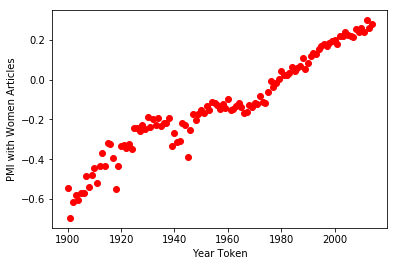

In [178]:
plt.plot(range(1900,2015), [pc.pmi(str(i)) for i in range(1900, 2015)], 'ro')
#plt.axis([0, 6, 0, 20])
plt.xlabel('Year Token')
plt.ylabel('PMI with Women Articles')
#plt.title('Histogram of IQ')
plt.show()

In [182]:
top_words_with_pmi.sort(key = lambda x: x[-1])

In [189]:
top_words_with_pmi[:25]

[('nbay', 26272, -7.611021034611001),
 ('soccerbase', 48215, -6.714110080527057),
 ('touchdowns', 21743, -5.717061075755479),
 ('cfb', 41858, -5.591893589120769),
 ('cfl', 27482, -4.883459824010785),
 ('ahl', 48558, -4.728768699616124),
 ('basho', 27121, -4.485825215739609),
 ('phillies', 18151, -4.408029612896608),
 ('ffffbf', 22239, -4.308870589754527),
 ('touchdown', 20951, -4.146025227102477),
 ('nhl', 152440, -3.980216647530143),
 ('packers', 17685, -3.8653300367238232),
 ('mlb', 112927, -3.765953985535786),
 ('nrl', 17001, -3.7100535643968486),
 ('ffdf9f', 30040, -3.667509684331198),
 ('dfdfdf', 30974, -3.6090002204332388),
 ('redskins', 17049, -3.541022692597691),
 ('sumo', 17618, -3.47376878974522),
 ('nfl', 198100, -3.362192971339228),
 ('braves', 21585, -3.3201713681263234),
 ('ligue', 20050, -3.3153947643584134),
 ('atp', 23513, -3.2587440084557056),
 ('calcio', 36112, -3.251651673848447),
 ('cardinals', 41157, -3.2000989189914497),
 ('hurling', 42983, -3.1796980729197557)]

In [188]:
top_words_with_pmi[-25:]

[('girl', 81774, 1.3043311692138673),
 ('karen', 18868, 1.3107377579413537),
 ('rachel', 19619, 1.320925870895616),
 ('jennifer', 24554, 1.3246692332215506),
 ('amy', 21268, 1.3468364575604284),
 ('laura', 28393, 1.3497051699823768),
 ('kate', 25335, 1.361659806311657),
 ('julie', 19482, 1.3677288569117696),
 ('lisa', 24538, 1.3794512862249828),
 ('gender', 20206, 1.3821934743321176),
 ('woman', 117209, 1.4085554659874795),
 ('gymnastics', 27011, 1.4361599930835922),
 ('girls', 57627, 1.443666437110494),
 ('jessica', 17538, 1.4518054969917902),
 ('michelle', 17688, 1.4548538222469443),
 ('miss', 83631, 1.4843674303589847),
 ('husband', 75006, 1.509566866723068),
 ('ladies', 25061, 1.5567496105259568),
 ('actress', 147860, 1.7006927238502563),
 ('her', 1308263, 1.7244667675788659),
 ('women', 532471, 1.742348800649344),
 ('female', 123970, 1.7434816438590204),
 ('herself', 41532, 1.75370262315033),
 ('she', 1412916, 1.7940272570088585),
 ('actresses', 93472, 1.8524058451615915)]

In [190]:
pc.pmi("wife")

-0.057060278138187925

In [191]:
pc.pmi("husband")

1.509566866723068

In [193]:
pc.pmi("calculus")

-1.3782836948463633

In [215]:
pc.pmi("algebra")

-0.43455580425201745

In [216]:
pc.pmi("geometry")

-0.7521868352706473

In [217]:
pc.pmi("manifold")

-0.9148179789333222

In [218]:
pc.pmi("vector")

-0.8668498910403404

In [208]:
pc.pmi("killed")

-0.438609525439805

In [205]:
pc.pmi("python")

-0.24261275656700754

In [206]:
pc.pmi("java")

-0.3288831679724957

In [210]:
pc.pmi("c")

-1.0698052654783705

In [211]:
pc.pmi("javascript")

-0.5527119286370876

In [213]:
pc.pmi("adascript")

0

In [219]:
[pc.pmi(word) for word in ['racist', 'bigot', 'sexist']]

[0.07980790465355447, -0.4304942959128377, 1.1057827364354074]

# Category Filtering

In [6]:
fp = FloatProgress(min=0, max=850399)
cc = IntText(value=0, description="Categories")
display(cc, fp)
article_count = 0
category_counts = None

matcher = re.compile("\[\[Category:([^\]]*)", re.IGNORECASE)

category_to_articles = collections.defaultdict(list)

with open("data/gendered-labeled-articles", 'r') as f:
    for line in f:
        article_count += 1
        if article_count % 1000 == 0:
            fp.value = article_count
            cc.value = len(category_to_articles)
        article_id = int(line.split(" ", 1)[0])
        for category in matcher.findall(line):
            category_to_articles[category].append(article_id)

IntText(value=0, description='Categories')

FloatProgress(value=0.0, max=850399.0)

In [8]:
topic_to_articles = collections.defaultdict(set)
topic_patterns = {
    "programming": re.compile("software|programmer"),
    "sports": re.compile("athlete|sportspeople"),
    "artists": re.compile("artist"),
    "scientist": re.compile("scientist"),
    "fictional": re.compile("fictional"),
    "monarch": re.compile("king|queen|monarch|royal|prince|princess"),
    
    
    #                          "politicians",
     #                         "military personnel",

                              #sportmanager
                              #cleric
       #                       "monarch",
        #                      "Fictional\ characters",
         #                     "nobility",
          #                    "criminals",
           #                   "judges"
    
}


for k,v in category_to_articles.items():
    for topic, pattern in topic_patterns.items():
        if pattern.search(k):
            topic_to_articles[topic].update(v)
            
[(k, len(v)) for (k,v) in topic_to_articles.items()]

[('sports', 22673),
 ('monarch', 12644),
 ('scientist', 10384),
 ('artists', 30265),
 ('programming', 1047),
 ('fictional', 4)]

In [9]:
fp = FloatProgress(min=0, max=850399)
display(fp)
article_count = 0

topic_writers = {topic: open("data/topic-" + topic + "words", 'w') for topic in topic_to_articles.keys()}

start = time.time()
try:
    with open("data/gendered-labeled-arlticles.stripped", 'r') as f:
        for line in f:
            article_count += 1
            if article_count % 1000 == 0:
                fp.value = article_count
            article_id, words = line.split(" ", 1)
            for topic, ids in topic_to_articles.items():
                if article_id in ids:
                    topic_writers[topic].write(words)
                    topic_writers[topic].write("\n")

finally:        
    for writer in topic_writers.values():
        writer.close()
    print("Articles:", article_count, "Time:", (time.time() - start), "seconds")

FloatProgress(value=0.0, max=850399.0)

Articles: 850399 Time: 7.9872894287109375 seconds


In [21]:
1+1

2

In [64]:
def parse_glove_file(file_path, ndim):
    # File path inside archive
    inner_path = "glove.6B.{:d}d.txt".format(ndim)
    print("Parsing file: {:s}:{:s}".format(file_path, inner_path))
    # Count lines to pre-allocate memory
    line_count = 0
    with open(file_path, 'r') as f:
        for line in f:
            line_count += 1
    print("Found {:,} words.".format(line_count))
    
    # Pre-allocate vectors as a contiguous array
    W = np.zeros((line_count, ndim), dtype=np.float32)
    words = []

    print("Parsing vectors... ", end="")
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            word, numbers = line.split(maxsplit=1)
            words.append(word)
            W[i] = np.fromstring(numbers, dtype=np.float32, sep=" ")
    
    print("Done! (W.shape = {:s})".format(str(W.shape)))
    return words, W

def find_nn_cos(v, Wv, k=10):
    cos_similarity = np.dot(Wv, v) / (np.linalg.norm(v) * np.linalg.norm(Wv, axis=1))
    nns = np.argsort(cos_similarity)[-k:]
    return (nns, cos_similarity[nns])

def analogy(vA, vB, vC, Wv, k=5):
    return find_nn_cos(vB - vA + vC, Wv, k)

class Glove:
    
    def __init__(self, file_path, ndim):
        self.words, self.W = parse_glove_file(file_path, ndim)
        self.word_index = {}
        for i, word in enumerate(self.words):
            self.word_index[word] = i
            
    def vector(self, word):
        return self.W[self.word_index[word]]
    
    def analogy(self, a, b, c, k=5):
        return [self.words[i] for i in analogy(self.vector(a), self.vector(b), self.vector(c), self.W, k)[0]]

In [20]:
glove = {}
glove["sports"] = {}
glove["sports"]["words"], glove["sports"]["W"] = word, W = parse_glove_file("data/glove/topic-sportswords-vectors.txt", 200)

Parsing file: data/glove/topic-sportswords-vectors.txt:glove.6B.200d.txt
Found 91,223 words.
Parsing vectors... Done! (W.shape = (91223, 200))


In [65]:
glove_all = Glove("data/glove/glove.6B.200d.txt", 200)

Parsing file: data/glove/glove.6B.200d.txt:glove.6B.200d.txt
Found 400,001 words.
Parsing vectors... Done! (W.shape = (400001, 200))


In [102]:
glove_all300 = Glove("data/glove/glove.6B.300d.txt", 300)

Parsing file: data/glove/glove.6B.300d.txt:glove.6B.300d.txt
Found 400,001 words.
Parsing vectors... Done! (W.shape = (400001, 300))


In [84]:
glove_programming = Glove("data/glove/topic-programmingwords-vectors.txt", 200)

Parsing file: data/glove/topic-programmingwords-vectors.txt:glove.6B.200d.txt
Found 17,607 words.
Parsing vectors... Done! (W.shape = (17607, 200))


In [69]:
glove_sports = Glove("data/glove/topic-sportswords-vectors.txt", 200)

Parsing file: data/glove/topic-sportswords-vectors.txt:glove.6B.200d.txt
Found 91,223 words.
Parsing vectors... Done! (W.shape = (91223, 200))


In [70]:
glove_science = Glove("data/glove/topic-scientistwords-vectors.txt", 200)

Parsing file: data/glove/topic-scientistwords-vectors.txt:glove.6B.200d.txt
Found 81,276 words.
Parsing vectors... Done! (W.shape = (81276, 200))


In [66]:
glove_all.analogy("man", "woman", "king")

['prince', 'monarch', 'princess', 'queen', 'king']

In [67]:
glove_all.analogy("he", "she", "king")

['elizabeth', 'prince', 'princess', 'queen', 'king']

In [68]:
glove_all.analogy("he", "she", "programmer")

['actress', 'animator', 'designer', 'programmers', 'programmer']

In [72]:
glove_sports.analogy("he", "she", "programmer")

['rapide', 'wezemaal', 'dorovskikh', 'sycv', 'lagging']

In [80]:
glove_all.analogy("he", "she", "man")

['she', 'mother', 'girl', 'man', 'woman']

In [83]:
glove_all.analogy("affect", "effect", "run")

['went', 'runs', 'running', 'ran', 'run']

In [85]:
glove_programming.analogy("he", "she", "compiler")

['annabella', 'her', 'she', 'pastel', 'compiler']

In [86]:
glove_all.analogy("he", "she", "compiler")

['fortran', 'runtime', 'c++', 'compilers', 'compiler']

In [91]:
glove_all.analogy("he", "she", "lisp")

['compilers', 'emacs', 'object-oriented', 'smalltalk', 'lisp']

In [95]:
glove_programming.analogy("he", "she", "compiler")

['annabella', 'her', 'she', 'pastel', 'compiler']

In [93]:
glove_programming.analogy("he", "she", "man")

['spider', 'burning', 'mythical', 'pac', 'man']

In [94]:
glove_all.analogy("he", "she", "man")

['she', 'mother', 'girl', 'man', 'woman']

In [82]:
glove_all.analogy("he", "she", "physics")

['science', 'biology', 'mathematics', 'chemistry', 'physics']

In [75]:
glove_all.analogy("man", "women", "calculus")

['curricula', 'mathematics', 'college-level', 'women', 'calculus']

In [76]:
glove_science.analogy("man", "women", "calculus")

['primatologists', 'ethologists', '20th', 'calculus', 'women']

In [81]:
glove_science.analogy("he", "she", "physics")

['theoretical', 'chemistry', 'her', 'she', 'physics']

In [77]:
glove_science.analogy("man", "women", "physics")

['20th', 'theoretical', 'chemistry', 'physics', 'women']

In [78]:
glove_all.analogy("man", "women", "physics")

['theoretical', 'women', 'biology', 'mathematics', 'physics']

In [108]:
glove_all.analogy("woman", "man", "biology")

['science', 'chemistry', 'biochemistry', 'physics', 'biology']

In [96]:
    glove_all.analogy("dog", "cat", "wolf")

['biermann', 'owl', 'leopard', 'cat', 'wolf']

In [97]:
glove_all.analogy("victory", "defeat", "love")

['tell', 'tells', 'lover', 'loves', 'love']

In [98]:
glove_all.analogy("hot", "cold", "love")

['loved', 'sense', 'betrayal', 'cold', 'love']

In [99]:
glove_all.analogy("good", "evil", "love")

['betrayal', 'lust', 'demons', 'love', 'evil']

In [101]:
glove_all.analogy("love", "hate", "nice")

['ought', 'nicer', 'folks', 'hate', 'nice']

In [109]:
glove_all300.analogy("he", "she", "man")

['mother', 'she', 'girl', 'man', 'woman']

In [103]:
glove_sports.analogy("good", "evil", "love")

['endless', 'bug', 'zumbano', 'evil', 'love']

In [105]:
glove_sports.analogy("baseball", "umpire", "football")

['theguardian', 'defender', 'striker', 'umpire', 'football']

In [106]:
glove_all.analogy("baseball", "umpire", "football")

['rudi', 'linesman', 'umpires', 'referee', 'umpire']

In [ ]:
glove_sports.analogy("baseball", "umpire", "football")